In [1]:
from src.investigative_experiments import prepare_data, train_model, population_level_decision_drivers, patient_specific_organ_preferences,cross_center_variation
from src.utils import create_dir_if_not_exist
import os

In [2]:
data_dir='./data'

hyper_parameters={'input_space':'X', 'criteria_space':'C', 'h_dim':30,'lambda_':0.01,'num_experts':20,'k':8, 'degree':1,'num_layers':1}
center_A='CTR16864'
center_B='CTR19034'
seed=19260817
max_iter=200

report_dir = os.path.join('report','main','investigative_experiments')
appendix_report_dir = os.path.join('report','appendix','investigative_experiments')
create_dir_if_not_exist(report_dir)
create_dir_if_not_exist(appendix_report_dir)

In [3]:
# Learn decision policies in center A
(X_train, y_train), (X_test, y_test), data_dict, column_dict = prepare_data(data_dir,center_A,seed=seed)
_ = train_model(center_A, X_train, y_train, data_dict, column_dict ,max_iter, seed, hyper_parameters)

train loss:0.077,valid loss:0.073:  26%|██▌       | 52/200 [01:05<03:06,  1.26s/it]

loss does not improve in 3 epoches, stop training at epoch 52, current loss: 0.07267104089260101
reloaded the best known model parameters


In [4]:
# Learn decision policies in center B
(X_train, y_train), (X_test, y_test), data_dict, column_dict = prepare_data(data_dir,center_B,seed=seed)
_ = train_model(center_B, X_train, y_train, data_dict, column_dict ,max_iter, seed, hyper_parameters)

train loss:0.074,valid loss:0.083:  30%|███       | 61/200 [01:22<03:07,  1.35s/it]

loss does not improve in 3 epoches, stop training at epoch 61, current loss: 0.08282442018389702
reloaded the best known model parameters


In [5]:
# Use data from center A for evaluations
(X_train, y_train), (X_test, y_test), data_dict, column_dict = prepare_data(data_dir,center_A,seed=seed)

# Results for the main manuscript

## 1. Discovering most significant decision drivers

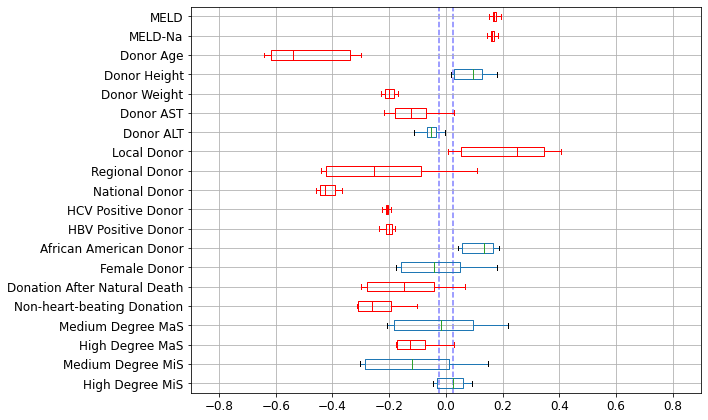

In [6]:
fig=population_level_decision_drivers(center_A, X_test, y_test, data_dict, column_dict,hyper_parameters)
fig.savefig(os.path.join(report_dir,'population_level_policy_signature_distribution.pdf'))
fig

## 2. Discovering patient-specific organ preferences of clinicians

In [7]:
ret_main, ret_appendix = patient_specific_organ_preferences(center_A, X_train, y_train, X_test, y_test, data_dict, column_dict, hyper_parameters, seed)

In [8]:
ret_main['cluster-wise patient feature distribution'].style.format('{:.2f}')

Compared to cluster 1, many patients in cluster 2 have positive HCC status and low MELD score (<=20).
Such differences in patient features distribution can be associated to the differences in clinicians' decision policy (policy signature distribution) for patients from these two clusters as shown below:
Organs allocated at the regional level (which leads to longer cold ischemia time) are more likely to be accepted for patients in cluster 2 compared to the population level average. This link between tolerance of longer cold ischemia time and HCC positive & low MELD score is supported by medical research on liver transplantation.

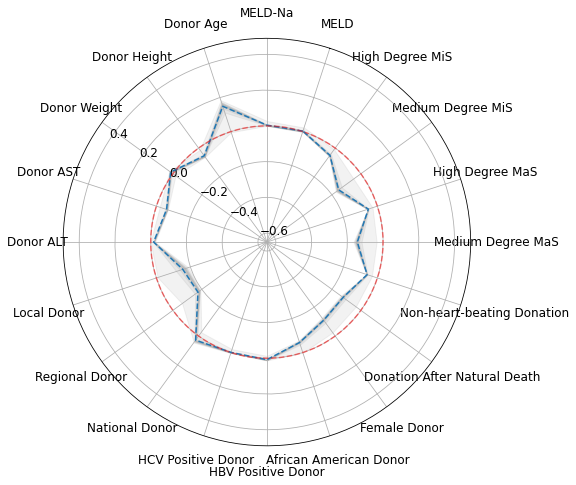

In [9]:
fig=ret_main['cluster-wise policy signature distribution']['cluster 1']
fig.savefig(os.path.join(report_dir,'policy_signature_deviation_cluster_1.pdf'))
fig

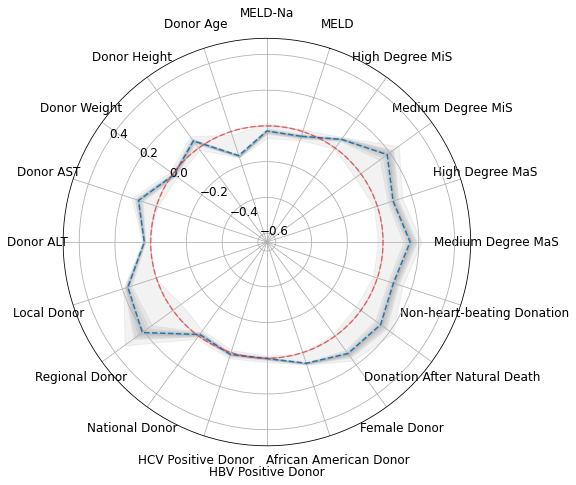

In [10]:
fig=ret_main['cluster-wise policy signature distribution']['cluster 2']
fig.savefig(os.path.join(report_dir,'policy_signature_deviation_cluster_2.pdf'))
fig

## 3. Discovering variations in polices across transplant centers

In [11]:
ret = cross_center_variation(center_A, center_B, X_test, y_test, data_dict, column_dict, hyper_parameters, seed=None, patient_idx=406)

In [12]:
ret['Population level deviations of learned policies'].style.set_caption('Comparison of acceptance rates predicted by policies learned from two centers')

In [13]:
ret['patient features'][['AGE','MELD_PELD_LAB_SCORE']].style.set_caption('Patient features')

In [14]:
ret['donor features'][['AGE_DON','SGOT_DON']].style.set_caption('Donor features')

### Counterfactual evaluation of the impact of donor organ features on the likelihood of organ offer acceptance
Policies learned from center A and center B are compared given difference donor AST/age.

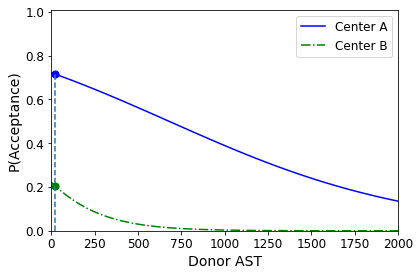

In [15]:
fig=ret['Counter factual donor AST']
fig.savefig(os.path.join(report_dir,'counter_factual_impact_donor_AST.pdf'))
fig

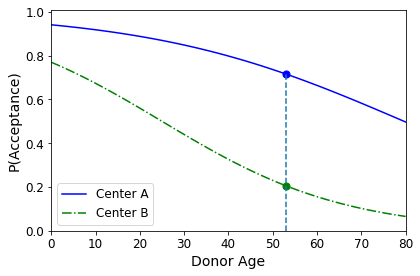

In [16]:
fig=ret['Counter factual donor age']
fig.savefig(os.path.join(report_dir,'counter_factual_impact_donor_age.pdf'))
fig

# Results for the appendix

## Performance gain over logistic regression in each patient cluster

In [17]:
ret_appendix['cluster-wise apr improvement'].style.format('{:.3f}')

## The selection probability of expert networks for patients in three different clusters (for the appendix)

To verify that different experts are assigned to different subsets of patients.

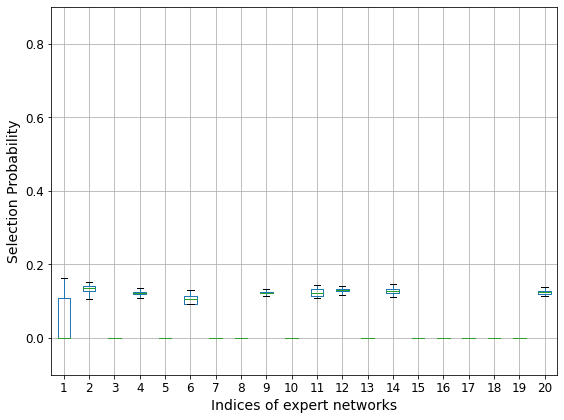

In [18]:
fig=ret_appendix['cluster-wise expert selection']['cluster 1']
fig.savefig(os.path.join(appendix_report_dir,'MoE selection probability in cluster 1.pdf'))
fig

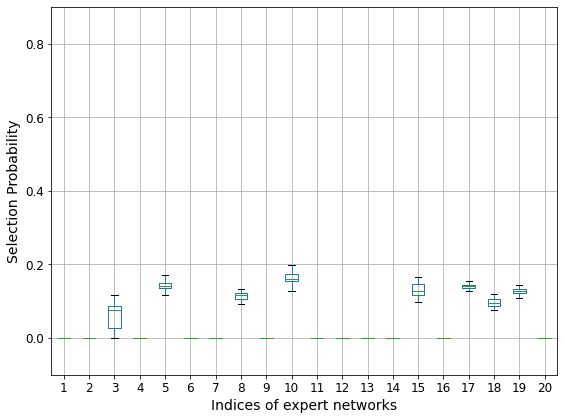

In [19]:
fig=ret_appendix['cluster-wise expert selection']['cluster 2']
fig.savefig(os.path.join(appendix_report_dir,'MoE selection probability in cluster 2.pdf'))
fig

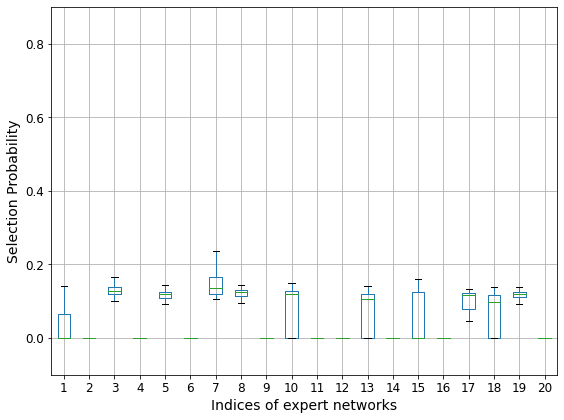

In [20]:
fig=ret_appendix['cluster-wise expert selection']['cluster 3']
fig.savefig(os.path.join(appendix_report_dir,'MoE selection probability in cluster 3.pdf'))
fig

## Comparison of decision boundaries discovered by a global logistic regression and by iTransplant (for the appendix)
To verify that iTransplant is able to adapt its decision boundaries for different cohorts of patients.

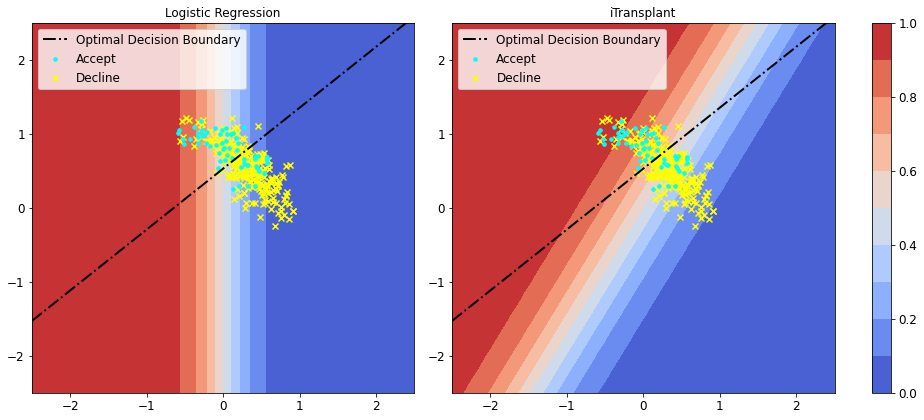

In [21]:
fig = ret_appendix['decision boundary comparison with LR']['cluster 2']
fig.savefig(os.path.join(appendix_report_dir,'decision boundary comparison with logistic regression in cluster 2.pdf'))
fig

## Decision boundaries in differnet patient clusters (with no less than 30 accepted organ offers in each cluster, for the appendix)  

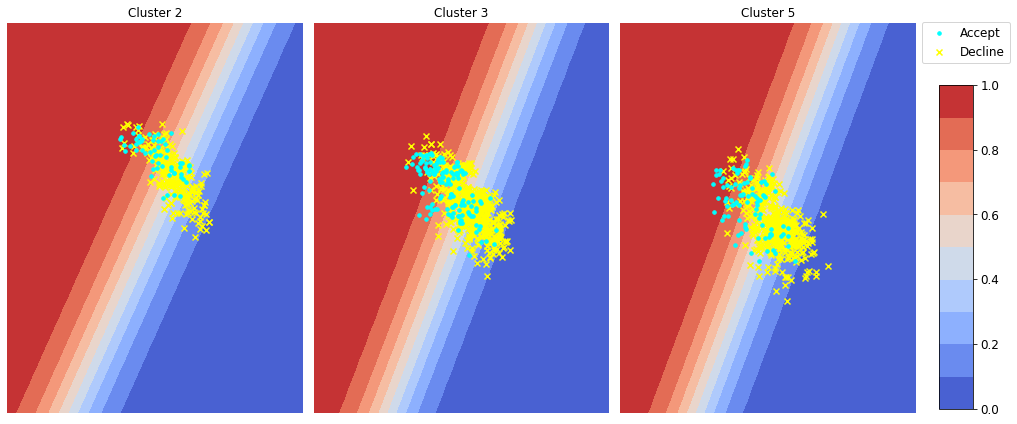

In [22]:
fig= ret_appendix['decision boundaries']
fig.savefig(os.path.join(appendix_report_dir,'decision boundaries.pdf'))
fig